## Setup and Data Loading

In [49]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
import importlib

sys.path.append('../scripts/')
import FeatureEngineering
importlib.reload(FeatureEngineering)


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:

path = '../data/consolidated/'
weather_data = pd.read_csv(path+'consolidated_weather_from_centroids.csv')
demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')
price_data = pd.read_csv(path+'prices_zonal.csv')

# convert temperature
columns = list(weather_data.columns)
columns[0] = 'Hour'
weather_data.columns = columns
weather_data['temp_C_t2m'] = weather_data['t2m'] - 273.15

# create proper dataset
dataset = FeatureEngineering.CleanedDataset(weather_data, demand_data, price_data)
datamerged = dataset.merge_datasets()
datamerged = dataset.add_calendar_features(datamerged)

print(f"Dataset shape: {datamerged.shape}")

/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8299/3273825869.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')


Dataset shape: (1905110, 46)


In [52]:
#create dummy variables for hour, month, weekday


print(datamerged.head())
print(datamerged.columns)


datamerged['Date'] = pd.to_datetime(datamerged['Date'])

# create dummy variables for hour, month, weekday
datamerged['hour'] = datamerged['Date'].dt.hour
datamerged['month'] = datamerged['Date'].dt.month
datamerged['weekday'] = datamerged['Date'].dt.weekday

# one hot
dummies = pd.get_dummies(datamerged[['hour', 'month', 'weekday']], columns=['hour', 'month', 'weekday'], prefix=['hour', 'month', 'weekday'])


datamerged = pd.concat([datamerged, dummies], axis=1)


print(datamerged.columns)

print(datamerged.filter(regex='hour_|month_|weekday_').head())

datamerged = datamerged[
    (datamerged['Date'].dt.year >= 2018) & 
    (datamerged['Date'].dt.year <= 2024)
]

                 Date  Hour  Ontario Demand  Northwest  Northeast  Ottawa  \
0 2015-09-06 16:00:00    16           20554        481       1232    1170   
1 2015-09-06 17:00:00    17           20415        495       1235    1148   
2 2015-09-06 18:00:00    18           19783        506       1242    1108   
3 2015-09-06 19:00:00    19           20198        513       1371    1170   
4 2015-09-06 20:00:00    20           19406        543       1391    1070   

   East  Toronto  Essa  Bruce  Southwest  Niagara  West  Zone Total  Diff  \
0  1371     7714  1234    104       4098      778  2188       20370  -184   
1  1474     7560  1275    101       4076      765  2197       20325   -90   
2  1456     7369  1265     93       3961      736  2167       19903   120   
3  1412     7413  1266     84       3976      724  2170       20098  -100   
4  1378     7207  1197     78       3814      697  2074       19450    44   

   Year    u10    v10      d2m      t2m         ssrd     tp  latitude  \
0

## 1. Multicollinearity Analysis

### 1.1 Correlation Matrix

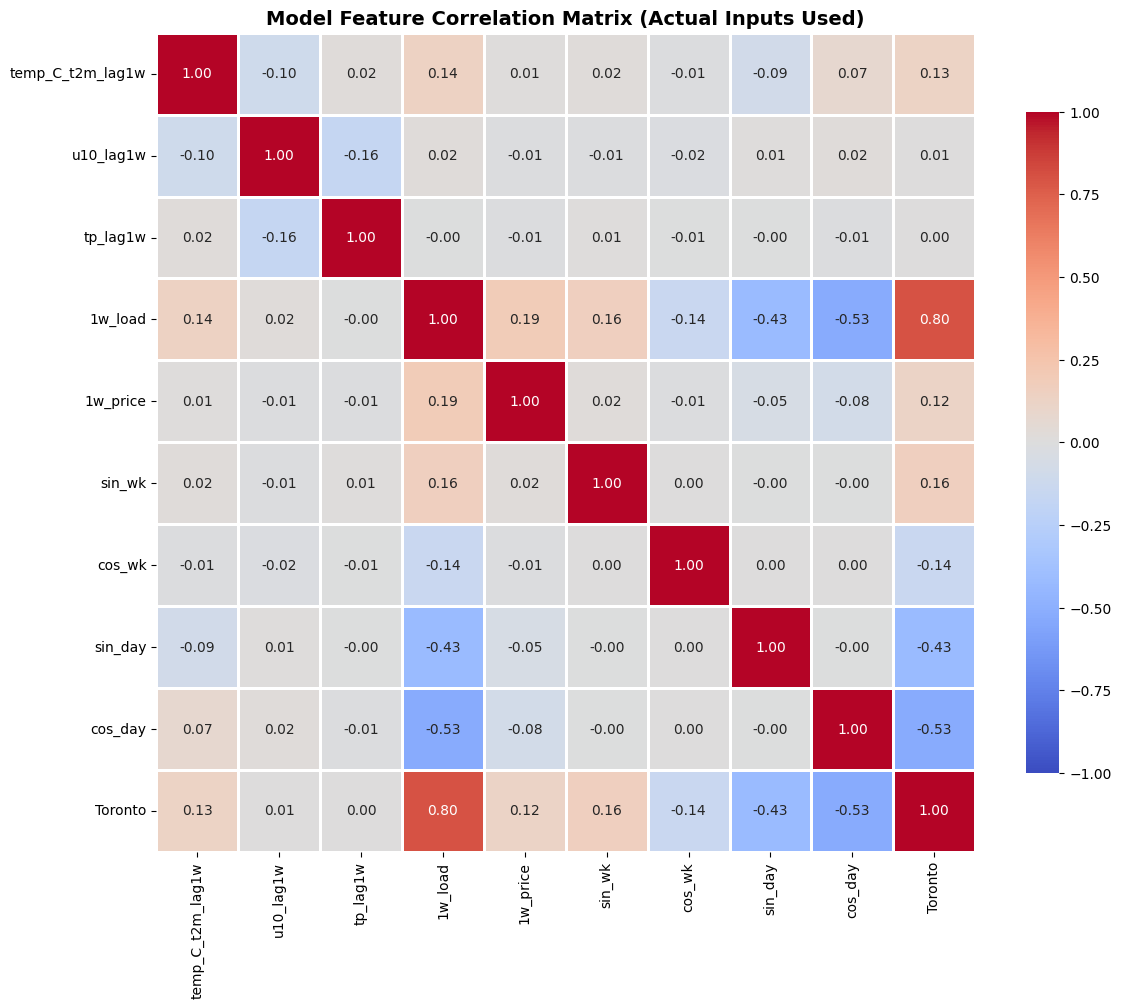


Highly correlated feature pairs (|r| > 0.7):
  1w_load <-> Toronto: 0.800


In [3]:
#feature engineering pipeline
import numpy as np

toronto_data = datamerged[datamerged['file'] == 'Toronto_centroid_weather'].copy()
toronto_data['Date'] = pd.to_datetime(toronto_data['Date'])
toronto_data = toronto_data[(toronto_data['Date'].dt.year >= 2018) & 
                            (toronto_data['Date'].dt.year <= 2024)]
toronto_data = toronto_data.set_index('Date').sort_index()

# fourier
toronto_data["t"] = np.arange(len(toronto_data))
period_weekly = 24 * 7
toronto_data["sin_wk"] = np.sin(2 * np.pi * toronto_data["t"] / period_weekly)
toronto_data["cos_wk"] = np.cos(2 * np.pi * toronto_data["t"] / period_weekly)
toronto_data["sin_day"] = np.sin(2 * np.pi * toronto_data["t"] / 24)
toronto_data["cos_day"] = np.cos(2 * np.pi * toronto_data["t"] / 24)

# lagged weather vars
toronto_data['temp_C_t2m_lag1w'] = toronto_data['temp_C_t2m'].shift(168)
toronto_data['u10_lag1w'] = toronto_data['u10'].shift(168)
toronto_data['tp_lag1w'] = toronto_data['tp'].shift(168)

# lagged load and price
toronto_data['1w_load'] = toronto_data['Toronto'].shift(168)
toronto_data['1w_price'] = toronto_data['Toronto_Darlington'].shift(168)

# drop nan
toronto_data = toronto_data.dropna(subset=['temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w', '1w_load', '1w_price'])

# select model features for correlation analysis (lagged versions + Fourier + current load)
model_continuous_features = [
    'temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w',  # Lagged weather (used in models)
    '1w_load', '1w_price',  # Lagged load and price
    'sin_wk', 'cos_wk', 'sin_day', 'cos_day',  # Fourier terms
    'Toronto'  # Target for reference
]
correlation_matrix = toronto_data[model_continuous_features].corr()

#heaptmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Model Feature Correlation Matrix (Actual Inputs Used)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#highly correlated pairs
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            correlation_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (|r| > 0.7):")
for feat1, feat2, corr in high_corr:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

### 1.2 Variance Inflation Factor (VIF)

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# prepare features for VIF calculation 
vif_features = [
    'temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w',
    '1w_load', '1w_price',
    'sin_wk', 'cos_wk', 'sin_day', 'cos_day'
]
X_vif = toronto_data[vif_features].dropna()

# calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_features
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(vif_features))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Variance Inflation Factors (Model Features):")
print(vif_data.to_string(index=False))
print("\nInterpretation:")
print("  VIF < 5: Low multicollinearity")
print("  5 ≤ VIF < 10: Moderate multicollinearity")
print("  VIF ≥ 10: High multicollinearity (potential concern)")

# check dummy variable multicollinearity
print("\n" + "="*80)
print("DUMMY VARIABLE MULTICOLLINEARITY")
print("="*80)
print("\nNote: One-hot encoded categorical variables have inherent multicollinearity:")
print("  - Hour dummies: 23 features (hour_1 to hour_23, reference=hour_0)")
print("  - Month dummies: 11 features (month_2 to month_12, reference=month_1)")
print("  - Weekday dummies: 6 features (weekday_1 to weekday_6, reference=weekday_0)")
print("\nThis is expected and addressed by dropping one reference category.")
print("VIF for dummy variables would be extremely high - not meaningful to calculate.")

Variance Inflation Factors (Model Features):
         Feature    VIF
         1w_load 2.4931
temp_C_t2m_lag1w 2.0284
        1w_price 1.1820
       u10_lag1w 1.1319
        tp_lag1w 1.1074
         cos_day 1.0405
         sin_day 1.0076
          sin_wk 1.0014
          cos_wk 1.0008

Interpretation:
  VIF < 5: Low multicollinearity
  5 ≤ VIF < 10: Moderate multicollinearity
  VIF ≥ 10: High multicollinearity (potential concern)

DUMMY VARIABLE MULTICOLLINEARITY

Note: One-hot encoded categorical variables have inherent multicollinearity:
  - Hour dummies: 23 features (hour_1 to hour_23, reference=hour_0)
  - Month dummies: 11 features (month_2 to month_12, reference=month_1)
  - Weekday dummies: 6 features (weekday_1 to weekday_6, reference=weekday_0)

This is expected and addressed by dropping one reference category.
VIF for dummy variables would be extremely high - not meaningful to calculate.


## 2. Feature Preparation with Groups

Based on correlation/VIF analysis, define feature groups for removal experiments

In [5]:
# Import data preparation function from training notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# ============================================================================
# Reusable Data Preparation Pipeline should work for all the data models
# ============================================================================

def prepare_toronto_load_data(
    datamerged,
    zone='Toronto_centroid_weather',
    weather_vars=None,
    extra_lags=None,  # list of tuples: (original_col, new_name, lag_hours)
    test_weeks=1,
    include_daily_seasonality=True
):
    """
    Prepare Toronto load data for time series modeling.
    
    parameters:
    datamerged : pd.DataFrame
        The merged dataset with all features
    zone : str
        Location identifier to filter by
    weather_vars : list, optional
        List of weather variables to use.
    extra_lags : list of tuples, optional
        Each tuple: (column_name, new_column_name, lag_hours)
    test_weeks : int
        Number of weeks for test set (default: 1 week = 168 hours)
    include_daily_seasonality : bool
        Whether to include daily sin/cos features (default: True)
    
    Returns:
    --------
    dict containing:
        - 'train': training dataset with datetime index
        - 'test': test dataset with datetime index
        - 'target_train': target variable for training
        - 'target_test': target variable for testing
        - 'exog_features': list of exogenous feature column names
        - 'toronto_data': full processed dataset
    """
    
    if weather_vars is None:
        weather_vars = ['temp_C_t2m', 'u10', 'tp']
    if extra_lags is None:
        extra_lags = []
    
    hours_per_week = 168
    
    # filter and prepare
    toronto_data = datamerged[datamerged['file'] == zone].copy()
    toronto_data['Date'] = pd.to_datetime(toronto_data['Date'])
    toronto_data = toronto_data.set_index('Date').sort_index()
    
    # time index for fourier terms
    toronto_data["t"] = np.arange(len(toronto_data))
    
    # weekly seasonality
    period_weekly = 24 * 7
    toronto_data["sin_wk"] = np.sin(2 * np.pi * toronto_data["t"] / period_weekly)
    toronto_data["cos_wk"] = np.cos(2 * np.pi * toronto_data["t"] / period_weekly)
    
    # daily seasonality 
    if include_daily_seasonality:
        toronto_data["sin_day"] = np.sin(2 * np.pi * toronto_data["t"] / 24)
        toronto_data["cos_day"] = np.cos(2 * np.pi * toronto_data["t"] / 24)
    
    # lag weather variables by 1 week
    for var in weather_vars:
        toronto_data[f'{var}_lag1w'] = toronto_data[var].shift(168)
    
    # lag extra columns by custom hours
    for col, new_name, lag_hours in extra_lags:
        toronto_data[new_name] = toronto_data[col].shift(lag_hours)
    
    # drop rows with NaN after lagging. this happens at the start sometimes.
    cols_to_check = [f'{v}_lag1w' for v in weather_vars] + ['Toronto']
    if extra_lags:
        cols_to_check += [new_name for _, new_name, _ in extra_lags]
    toronto_data = toronto_data.dropna(subset=cols_to_check)
    
    # e xtract dummy variables 
    hour_dummies = [c for c in toronto_data.columns if c.startswith('hour_')][1:]
    month_dummies = [c for c in toronto_data.columns if c.startswith('month_')][1:]
    weekday_dummies = [c for c in toronto_data.columns if c.startswith('weekday_')][1:]
    
    # bild exogenous features list ---
    seasonal_features = ["sin_wk", "cos_wk"]
    if include_daily_seasonality:
        seasonal_features += ['sin_day', 'cos_day']

    exog_features = (
        hour_dummies +
        month_dummies +
        weekday_dummies +
        [f'{v}_lag1w' for v in weather_vars] +
        seasonal_features
    )
    
    # holidays addition
    if 'IsHoliday' in toronto_data.columns:
        exog_features += ['IsHoliday']
    
    if extra_lags:
        exog_features += [new_name for _, new_name, _ in extra_lags]

    # Ensure all feature columns are numeric before splitting
    for col in exog_features:
        toronto_data[col] = pd.to_numeric(toronto_data[col], errors='coerce')
    toronto_data[exog_features] = toronto_data[exog_features].fillna(0)
    
    # train/test split
    train = toronto_data.iloc[:-hours_per_week * test_weeks]
    test = toronto_data.iloc[-hours_per_week * test_weeks:]
    
    # ensure numeric for exogenous features
    for df in [train, test]:
        df[exog_features] = df[exog_features].astype(float)
    
    target_train = train['Toronto'].astype(float)
    target_test = test['Toronto'].astype(float)
    
    return {
        'train': train,
        'test': test,
        'target_train': target_train,
        'target_test': target_test,
        'exog_features': exog_features,
        'toronto_data': toronto_data
    }

print("Data preparation function loaded")

/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Data preparation function loaded


## 3. Feature Importance by Model

### 3.1 Bayesian Ridge Regression: Coefficient Analysis

In [7]:
# prepare data


data = prepare_toronto_load_data(
    datamerged,
    zone='Toronto_centroid_weather',
    weather_vars=['temp_C_t2m', 'u10', 'tp'],
    extra_lags=[
        ('Toronto', '1w_load', 168),
        ('Toronto_Darlington', '1w_price', 168)
    ],
    test_weeks=40,
    include_daily_seasonality=True
)
#only train on years 2018-2024

train = data['train']
test = data['test']
target_train = data['target_train']
target_test = data['target_test']
exog_features = data['exog_features']

# train model brr
scaler = StandardScaler()
# the model only ever sees the train's mean -- NOT TEST. so this is not data leakage. 
# the standardization is not performed on data it hasn't seen in test. it uses train's sample mean.
X_train_scaled = scaler.fit_transform(train[exog_features].astype(float))
X_test_scaled = scaler.transform(test[exog_features].astype(float))

model = BayesianRidge()
model.fit(X_train_scaled, target_train)

# analyze coefficients
feature_importance = pd.DataFrame({
    'Feature': exog_features,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 20 Most Important Features (Bayesian Ridge):")
print(feature_importance.head(20).to_string(index=False))


Top 20 Most Important Features (Bayesian Ridge):
         Feature  Coefficient  Abs_Coefficient
         1w_load     648.6490         648.6490
         cos_day    -208.0538         208.0538
         sin_day    -157.1419         157.1419
       IsHoliday    -107.9885         107.9885
          cos_wk      88.0132          88.0132
          sin_wk     -47.6029          47.6029
        1w_price     -14.0344          14.0344
       u10_lag1w      10.7257          10.7257
temp_C_t2m_lag1w      10.6848          10.6848
        tp_lag1w      -0.9585           0.9585


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8299/3804223725.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8299/3804223725.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].astype(float)


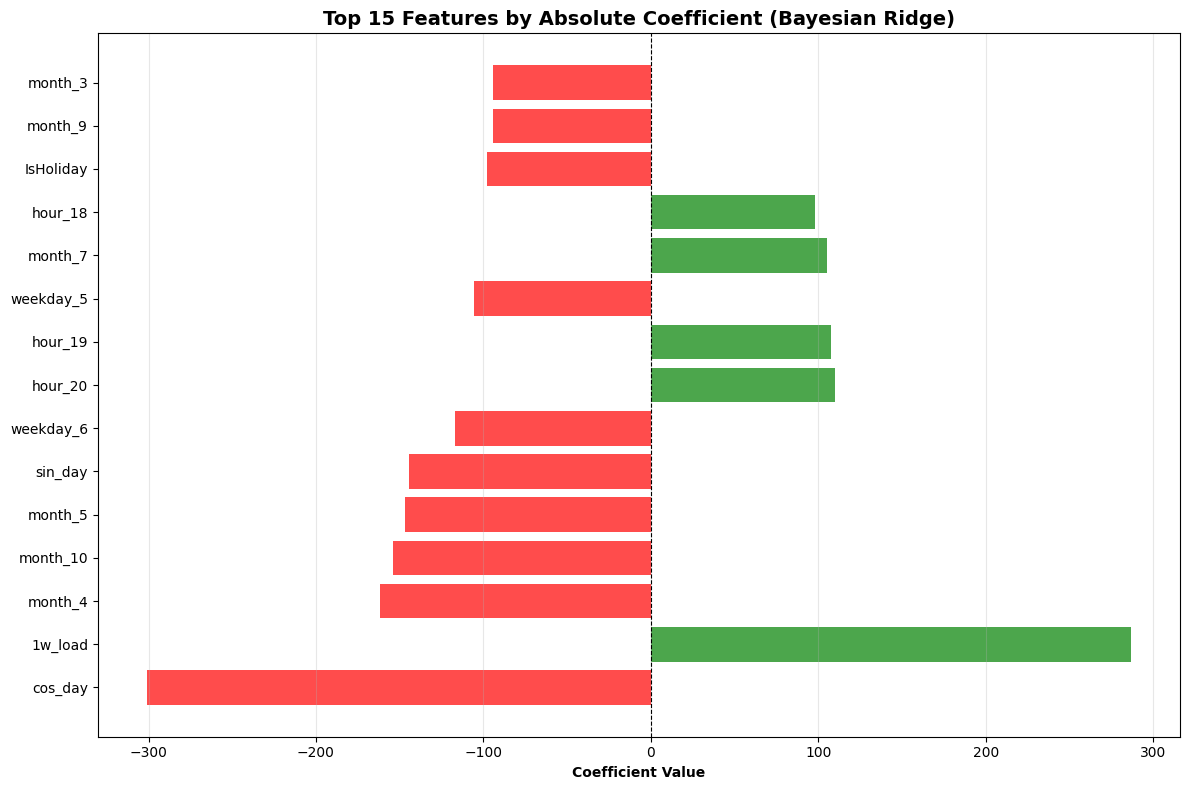

In [59]:
# visualize top features
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontweight='bold')
plt.title(f'Top {top_n} Features by Absolute Coefficient (Bayesian Ridge)', 
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 ARIMAX: Coefficient Significance

In [8]:
# Define variables for rolling forecast
forecast_horizon = 168  # 1 week
max_weeks = 40 # limit number of weeks to forecast

# Get full dataset for rolling window
full_data = data['toronto_data']

# Find initial training end index (start of test set)
initial_train_end = full_data.index.get_loc(test.index[0])

In [58]:
# --- Rolling Forecast Evaluation for ARIMAX ---
print("\nStarting rolling forecast for ARIMAX...")
all_preds_arimax = []
all_actuals_arimax = []
max_weeks = 40
for week in range(max_weeks):
    current_train_end = initial_train_end + (week * forecast_horizon)
    forecast_end = current_train_end + forecast_horizon
    if forecast_end > len(full_data):
        forecast_end = len(full_data)

    expanding_train = full_data.iloc[:current_train_end]
    forecast_data = full_data.iloc[current_train_end:forecast_end]

    if forecast_data.empty:
        break

    y_train = expanding_train['Toronto'].astype(float)
    X_train = expanding_train[exog_features].astype(float)
    X_forecast = forecast_data[exog_features].astype(float)
    y_actual = forecast_data['Toronto'].astype(float)

    arimax_model = SARIMAX(
        y_train,
        exog=X_train,
        order=(1, 1, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    arimax_results = arimax_model.fit(disp=False)
    
    # Forecast for the next week
    forecast = arimax_results.get_forecast(steps=len(X_forecast), exog=X_forecast)
    preds = forecast.predicted_mean
    
    all_preds_arimax.extend(preds)
    all_actuals_arimax.extend(y_actual.values)
    
    if (week + 1) % 10 == 0:
        print(f"  Week {week + 1}/{max_weeks} completed.")

# Get coefficients from the last trained model
params = arimax_results.params
pvalues = arimax_results.pvalues
exog_params = params[params.index.isin(exog_features)]
exog_pvalues = pvalues[pvalues.index.isin(exog_features)]

arimax_importance = pd.DataFrame({
    'Feature': exog_params.index,
    'Coefficient': exog_params.values,
    'P-value': exog_pvalues.values
}).sort_values('P-value')

print("\nTop 20 Most Significant Features (ARIMAX from last window):")
print(arimax_importance.head(20).to_string(index=False))

rmse_arimax = np.sqrt(mean_squared_error(all_actuals_arimax, all_preds_arimax))
print(f"\nRolling ARIMAX RMSE: {rmse_arimax:.2f} MW")


Starting rolling forecast for ARIMAX...


NameError: name 'max_weeks' is not defined

### 3.3 Prophet: Regressor Components

In [11]:
# rolling forecast evaluation forprophet 
print("\nStarting rolling forecast for Prophet...")

# emove Fourier terms
prophet_exog_features = [f for f in exog_features if 'sin' not in f and 'cos' not in f]

all_preds_prophet = []
all_actuals_prophet = []

# retrain for every week
for week in range(max_weeks):
    current_train_end = initial_train_end + (week * forecast_horizon)
    forecast_end = current_train_end + forecast_horizon
    if forecast_end > len(full_data):
        forecast_end = len(full_data)

    expanding_train = full_data.iloc[:current_train_end]
    forecast_data = full_data.iloc[current_train_end:forecast_end]

    if forecast_data.empty:
        break

    # repare training data for Prophet
    prophet_train_df = pd.DataFrame({
        'ds': expanding_train.index,
        'y': expanding_train['Toronto'].values
    })
    for col in prophet_exog_features:
        prophet_train_df[col] = expanding_train[col].values

    # initialize and fit Prophet model
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True
    )
    for col in prophet_exog_features:
        prophet_model.add_regressor(col)
    
    prophet_model.fit(prophet_train_df)

    # future dataframe for prediction
    future_df = pd.DataFrame({'ds': forecast_data.index})
    for col in prophet_exog_features:
        future_df[col] = forecast_data[col].values
        
    # forecast
    forecast = prophet_model.predict(future_df)
    preds = forecast['yhat'].values
    
    all_preds_prophet.extend(preds)
    all_actuals_prophet.extend(forecast_data['Toronto'].values)
    
    if (week + 1) % 10 == 0:
        print(f"  Week {week + 1}/{max_weeks} completed.")

# analyze regressor coefficients from the last model
from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(prophet_model)
print("\nRegressor Coefficients (Prophet from last window):")
print(regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef').to_string(index=False))

rmse_prophet = np.sqrt(mean_squared_error(all_actuals_prophet, all_preds_prophet))
print(f"\nRolling Prophet RMSE: {rmse_prophet:.2f} MW")


Starting rolling forecast for Prophet...


10:12:01 - cmdstanpy - INFO - Chain [1] start processing
10:12:38 - cmdstanpy - INFO - Chain [1] done processing
10:12:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:20 - cmdstanpy - INFO - Chain [1] done processing
10:13:25 - cmdstanpy - INFO - Chain [1] start processing
10:14:04 - cmdstanpy - INFO - Chain [1] done processing
10:14:09 - cmdstanpy - INFO - Chain [1] start processing
10:14:45 - cmdstanpy - INFO - Chain [1] done processing
10:14:50 - cmdstanpy - INFO - Chain [1] start processing
10:15:30 - cmdstanpy - INFO - Chain [1] done processing
10:15:35 - cmdstanpy - INFO - Chain [1] start processing
10:16:26 - cmdstanpy - INFO - Chain [1] done processing
10:16:31 - cmdstanpy - INFO - Chain [1] start processing
10:17:20 - cmdstanpy - INFO - Chain [1] done processing
10:17:25 - cmdstanpy - INFO - Chain [1] start processing
10:18:04 - cmdstanpy - INFO - Chain [1] done processing
10:18:09 - cmdstanpy - INFO - Chain [1] start processing
10:18:50 - cmdstanpy - INFO - Chain [1]

  Week 10/40 completed.


10:19:36 - cmdstanpy - INFO - Chain [1] start processing
10:20:22 - cmdstanpy - INFO - Chain [1] done processing
10:20:27 - cmdstanpy - INFO - Chain [1] start processing
10:21:05 - cmdstanpy - INFO - Chain [1] done processing
10:21:09 - cmdstanpy - INFO - Chain [1] start processing
10:21:53 - cmdstanpy - INFO - Chain [1] done processing
10:21:58 - cmdstanpy - INFO - Chain [1] start processing
10:22:37 - cmdstanpy - INFO - Chain [1] done processing
10:22:42 - cmdstanpy - INFO - Chain [1] start processing
10:23:26 - cmdstanpy - INFO - Chain [1] done processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:24:15 - cmdstanpy - INFO - Chain [1] done processing
10:24:20 - cmdstanpy - INFO - Chain [1] start processing
10:25:07 - cmdstanpy - INFO - Chain [1] done processing
10:25:11 - cmdstanpy - INFO - Chain [1] start processing
10:26:06 - cmdstanpy - INFO - Chain [1] done processing
10:26:11 - cmdstanpy - INFO - Chain [1] start processing
10:26:53 - cmdstanpy - INFO - Chain [1]

  Week 20/40 completed.


10:27:53 - cmdstanpy - INFO - Chain [1] start processing
10:28:40 - cmdstanpy - INFO - Chain [1] done processing
10:28:45 - cmdstanpy - INFO - Chain [1] start processing
10:29:24 - cmdstanpy - INFO - Chain [1] done processing
10:29:29 - cmdstanpy - INFO - Chain [1] start processing
10:30:10 - cmdstanpy - INFO - Chain [1] done processing
10:30:14 - cmdstanpy - INFO - Chain [1] start processing
10:31:00 - cmdstanpy - INFO - Chain [1] done processing
10:31:05 - cmdstanpy - INFO - Chain [1] start processing
10:31:43 - cmdstanpy - INFO - Chain [1] done processing
10:31:49 - cmdstanpy - INFO - Chain [1] start processing
10:32:29 - cmdstanpy - INFO - Chain [1] done processing
10:32:34 - cmdstanpy - INFO - Chain [1] start processing
10:33:17 - cmdstanpy - INFO - Chain [1] done processing
10:33:22 - cmdstanpy - INFO - Chain [1] start processing
10:33:56 - cmdstanpy - INFO - Chain [1] done processing
10:34:01 - cmdstanpy - INFO - Chain [1] start processing
10:34:45 - cmdstanpy - INFO - Chain [1]

  Week 30/40 completed.


10:35:33 - cmdstanpy - INFO - Chain [1] start processing
10:36:12 - cmdstanpy - INFO - Chain [1] done processing
10:36:17 - cmdstanpy - INFO - Chain [1] start processing
10:36:50 - cmdstanpy - INFO - Chain [1] done processing
10:36:55 - cmdstanpy - INFO - Chain [1] start processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing
10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:38:19 - cmdstanpy - INFO - Chain [1] done processing
10:38:24 - cmdstanpy - INFO - Chain [1] start processing
10:38:57 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:36 - cmdstanpy - INFO - Chain [1] done processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:40:16 - cmdstanpy - INFO - Chain [1] done processing
10:40:21 - cmdstanpy - INFO - Chain [1] start processing
10:41:02 - cmdstanpy - INFO - Chain [1] done processing
10:41:07 - cmdstanpy - INFO - Chain [1] start processing
10:41:46 - cmdstanpy - INFO - Chain [1]

  Week 40/40 completed.

Regressor Coefficients (Prophet from last window):
       regressor regressor_mode      coef
       IsHoliday       additive -688.4115
temp_C_t2m_lag1w       additive   -5.5867
        1w_price       additive   -0.0327
       u10_lag1w       additive    0.0945
         1w_load       additive    0.3151
        tp_lag1w       additive 3193.6020

Rolling Prophet RMSE: 415.64 MW


In [ ]:
#print prophet rmse on the last training fold
last_train_preds = prophet_model.predict(prophet_train_df)['yhat']
last_train_actuals = prophet_train_df['y']
rmse = np.sqrt(mean_squared_error(last_train_actuals, last_train_preds))
rmse

ValueError: Found input variables with inconsistent numbers of samples: [180119, 186671]

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def prophet_permutation_importance(model, df, exog_features, metric=mean_absolute_error):
    """
    Compute permutation importance for a fitted Prophet model.
    
    Parameters:
        model: Fitted Prophet model
        df: DataFrame used for prediction (must contain ds, y, and regressors)
        exog_features: List of regressor names
        metric: Error metric function (default MAE)
        
    Returns:
        Dictionary of feature: importance_score
    """
    
    # baseline predictioj
    baseline_pred = model.predict(df)
    baseline_err = metric(df['y'], baseline_pred['yhat'])

    importances = {}

    for col in exog_features:
        df_permuted = df.copy()
        df_permuted[col] = np.random.permutation(df_permuted[col])

        pred = model.predict(df_permuted)
        err = metric(df['y'], pred['yhat'])

        importances[col] = err - baseline_err  # Error increase

    return dict(sorted(importances.items(), key=lambda x: -x[1]))




# same dataset
importance_scores = prophet_permutation_importance(
    prophet_model,
    prophet_train,
    exog_features,
    metric=mean_absolute_error
)

importance_scores


{'1w_load': 168.36450957876002,
 'month_12': 66.7117816751782,
 'month_10': 62.988537907693626,
 'month_11': 60.433133399526696,
 'month_7': 56.15294792676917,
 'month_9': 51.29188891067594,
 'month_8': 46.55295552921217,
 'month_6': 37.54977447563556,
 'weekday_5': 27.802783585419377,
 'weekday_6': 20.555257684406854,
 'IsHoliday': 18.761786180482773,
 'weekday_3': 11.312629176486041,
 'weekday_4': 11.176057503310574,
 'temp_C_t2m_lag1w': 8.560728643196569,
 'weekday_2': 6.5095053359442545,
 'weekday_1': 3.3215226096774018,
 'month_5': 2.713247485032923,
 'month_4': 2.089343652535945,
 'month_3': 1.8494492929423245,
 'month_2': 0.8914673081881119,
 'hour_17': 0.722878753411635,
 'hour_7': 0.5395191048680772,
 'hour_21': 0.4333860149500879,
 'hour_20': 0.3887599980298546,
 'hour_18': 0.3665425292969644,
 'hour_11': 0.30611880994302965,
 'hour_19': 0.21651745426026991,
 'hour_10': 0.2028771422459954,
 'hour_16': 0.20286575333187784,
 'hour_6': 0.19031021869460574,
 'hour_12': 0.13658595

## 4. Feature Ablation Study

Systematically remove feature groups and measure performance degradation

In [ ]:
# define feature groups
feature_groups = {
    'Weather': ['temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w'],
    'Price': ['1w_price'],
    'Historical Load': ['1w_load'],
    'Fourier (Weekly)': ['sin_wk', 'cos_wk'],
    'Fourier (Daily)': ['sin_day', 'cos_day'],
    'Hour Dummies': [c for c in exog_features if c.startswith('hour_')],
    'Month Dummies': [c for c in exog_features if c.startswith('month_')],
    'Weekday Dummies': [c for c in exog_features if c.startswith('weekday_')],
    'Holiday': ['IsHoliday'] if 'IsHoliday' in exog_features else []
}

print("Feature Groups Defined:")
for group_name, features in feature_groups.items():
    if features:
        print(f"  {group_name}: {len(features)} features")

Feature Groups Defined:
  Weather: 3 features
  Price: 1 features
  Historical Load: 1 features
  Fourier (Weekly): 2 features
  Fourier (Daily): 2 features
  Hour Dummies: 23 features
  Month Dummies: 11 features
  Weekday Dummies: 6 features
  Holiday: 1 features


### 4.1 Ablation with Bayesian Ridge (Fast)

In [ ]:
def evaluate_with_rolling_forecast(
    full_data, 
    initial_train_end_idx, 
    target_col, 
    feature_set, 
    forecast_horizon=168, 
    max_weeks=40
):
    """
    Evaluates a feature set using a rolling forecast with an expanding window.
    """
    all_pred = []
    all_actual = []

    for week in range(max_weeks):
        current_train_end = initial_train_end_idx + (week * forecast_horizon)
        forecast_end = current_train_end + forecast_horizon
        
        if forecast_end > len(full_data):
            forecast_end = len(full_data)
            if forecast_end <= current_train_end:
                break
        
        expanding_train = full_data.iloc[:current_train_end]
        expanding_target = expanding_train[target_col].astype(float)
        
        forecast_data = full_data.iloc[current_train_end:forecast_end]
        actual_values = forecast_data[target_col].astype(float)
        
        X_train = expanding_train[feature_set].astype(float)
        X_forecast = forecast_data[feature_set].astype(float)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_forecast_scaled = scaler.transform(X_forecast)

        model = BayesianRidge()
        model.fit(X_train_scaled, expanding_target)

        pred_mean = model.predict(X_forecast_scaled)

        all_pred.extend(pred_mean)
        all_actual.extend(actual_values.values)

    return np.sqrt(mean_squared_error(all_actual, all_pred))

# Get the full dataset and the split point for the rolling forecast
full_toronto_data = data['toronto_data']
test_start_index = full_toronto_data.index.get_loc(test.index[0])

print("Rolling forecast evaluation function is ready.")

In [ ]:
def evaluate_with_rolling_forecast(
    full_data, 
    initial_train_end_idx, 
    target_col, 
    feature_set, 
    forecast_horizon=168, 
    max_weeks=40
):
    """
    Evaluates a feature set using a rolling forecast with an expanding window.
    """
    all_pred = []
    all_actual = []

    for week in range(max_weeks):
        current_train_end = initial_train_end_idx + (week * forecast_horizon)
        forecast_end = current_train_end + forecast_horizon
        
        if forecast_end > len(full_data):
            forecast_end = len(full_data)
            if forecast_end <= current_train_end:
                break
        
        expanding_train = full_data.iloc[:current_train_end]
        expanding_target = expanding_train[target_col].astype(float)
        
        forecast_data = full_data.iloc[current_train_end:forecast_end]
        actual_values = forecast_data[target_col].astype(float)
        
        X_train = expanding_train[feature_set].astype(float)
        X_forecast = forecast_data[feature_set].astype(float)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_forecast_scaled = scaler.transform(X_forecast)

        model = BayesianRidge()
        model.fit(X_train_scaled, expanding_target)

        pred_mean = model.predict(X_forecast_scaled)

        all_pred.extend(pred_mean)
        all_actual.extend(actual_values.values)

    return np.sqrt(mean_squared_error(all_actual, all_pred))

# Get the full dataset and the split point for the rolling forecast
full_toronto_data = data['toronto_data']
test_start_index = full_toronto_data.index.get_loc(test.index[0])

print("Rolling forecast evaluation function is ready.")

In [ ]:
def evaluate_with_rolling_forecast(
    full_data, 
    initial_train_end_idx, 
    target_col, 
    feature_set, 
    forecast_horizon=168, 
    max_weeks=40
):
    """
    Evaluates a feature set using a rolling forecast with an expanding window.
    """
    all_pred = []
    all_actual = []

    for week in range(max_weeks):
        current_train_end = initial_train_end_idx + (week * forecast_horizon)
        forecast_end = current_train_end + forecast_horizon
        
        if forecast_end > len(full_data):
            forecast_end = len(full_data)
            if forecast_end <= current_train_end:
                break
        
        expanding_train = full_data.iloc[:current_train_end]
        expanding_target = expanding_train[target_col].astype(float)
        
        forecast_data = full_data.iloc[current_train_end:forecast_end]
        actual_values = forecast_data[target_col].astype(float)
        
        X_train = expanding_train[feature_set].astype(float)
        X_forecast = forecast_data[feature_set].astype(float)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_forecast_scaled = scaler.transform(X_forecast)

        model = BayesianRidge()
        model.fit(X_train_scaled, expanding_target)

        pred_mean = model.predict(X_forecast_scaled)

        all_pred.extend(pred_mean)
        all_actual.extend(actual_values.values)

    return np.sqrt(mean_squared_error(all_actual, all_pred))

# Get the full dataset and the split point for the rolling forecast
full_toronto_data = data['toronto_data']
test_start_index = full_toronto_data.index.get_loc(test.index[0])

print("Rolling forecast evaluation function is ready.")

Rolling forecast evaluation function is ready.


In [ ]:
# Baseline performance with rolling forecast
print("Calculating baseline RMSE with rolling forecast...")
baseline_rmse = evaluate_with_rolling_forecast(
    full_data=full_toronto_data,
    initial_train_end_idx=test_start_index,
    target_col='Toronto',
    feature_set=exog_features
)
print(f"Baseline Rolling RMSE (All Features): {baseline_rmse:.2f} MW\n")

# Ablation results using rolling forecast
ablation_results = []

for group_name, features_to_remove in feature_groups.items():
    if not features_to_remove:
        continue
    
    remaining_features = [f for f in exog_features if f not in features_to_remove]
    
    if not remaining_features:
        continue
        
    print(f"Evaluating with '{group_name}' group removed...")
    
    # Evaluate this ablated feature set with the rolling forecast
    rmse_ablated = evaluate_with_rolling_forecast(
        full_data=full_toronto_data,
        initial_train_end_idx=test_start_index,
        target_col='Toronto',
        feature_set=remaining_features
    )
    
    ablation_results.append({
        'Feature Group': group_name,
        'Features Removed': len(features_to_remove),
        'RMSE': rmse_ablated,
        'RMSE Change': rmse_ablated - baseline_rmse,
        'RMSE % Change': ((rmse_ablated - baseline_rmse) / baseline_rmse * 100)
    })

ablation_df = pd.DataFrame(ablation_results).sort_values('RMSE Change', ascending=False)

print("\n" + "="*80)
print("FEATURE ABLATION RESULTS (Rolling Forecast Evaluation)")
print("="*80)
print(ablation_df.to_string(index=False))
print("\nInterpretation: Positive change = performance degraded when group removed")

Baseline (All Features):
  RMSE: 416.85 MW
  MAE: 309.98 MW

FEATURE ABLATION RESULTS (Bayesian Ridge)
   Feature Group  Features Removed     RMSE      MAE  RMSE Change  MAE Change  RMSE % Change
    Hour Dummies                23 491.1863 344.9701      74.3358     34.9901        17.8327
   Month Dummies                11 470.1806 354.6080      53.3302     44.6280        12.7936
 Historical Load                 1 445.0377 339.0917      28.1873     29.1117         6.7620
 Weekday Dummies                 6 435.0165 314.3030      18.1660      4.3230         4.3579
         Holiday                 1 434.3089 320.4342      17.4585     10.4542         4.1882
         Weather                 3 416.5957 308.8587      -0.2547     -1.1214        -0.0611
Fourier (Weekly)                 2 416.4479 309.1639      -0.4025     -0.8162        -0.0966
 Fourier (Daily)                 2 416.4479 309.1639      -0.4025     -0.8162        -0.0966
           Price                 1 416.2407 308.8658      -0

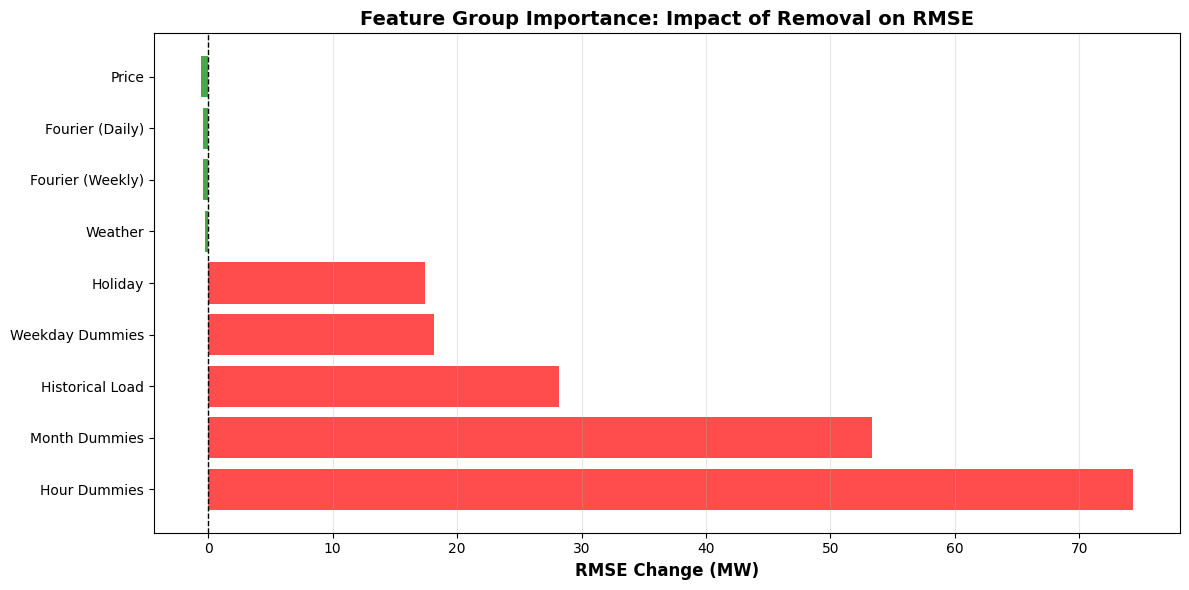

In [ ]:
# Visualize ablation impact
plt.figure(figsize=(12, 6))
colors = ['red' if x > 0 else 'green' for x in ablation_df['RMSE Change']]
plt.barh(ablation_df['Feature Group'], ablation_df['RMSE Change'], color=colors, alpha=0.7)
plt.xlabel('RMSE Change (MW)', fontweight='bold', fontsize=12)
plt.title('Feature Group Importance: Impact of Removal on RMSE', 
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Summary and Conclusions

In [ ]:
print("="*80)
print("RQ2 ANALYSIS SUMMARY")
print("="*80)
print("\n1. MULTICOLLINEARITY:")
print(f"   - Features with high VIF (>10): {len(vif_data[vif_data['VIF'] >= 10])}")
print(f"   - Highly correlated pairs (|r|>0.7): {len(high_corr)}")

print("\n2. MOST IMPORTANT FEATURES (Bayesian Ridge):")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Coefficient']:.4f}")

print("\n3. FEATURE GROUPS WITH LARGEST IMPACT WHEN REMOVED:")
for i, row in ablation_df.head(5).iterrows():
    print(f"   - {row['Feature Group']}: +{row['RMSE Change']:.2f} MW ({row['RMSE % Change']:.1f}%)")

print("\n4. FEATURE GROUPS WITH MINIMAL IMPACT:")
for i, row in ablation_df.tail(3).iterrows():
    print(f"   - {row['Feature Group']}: {row['RMSE Change']:+.2f} MW ({row['RMSE % Change']:+.1f}%)")

print("\n" + "="*80)

RQ2 ANALYSIS SUMMARY

1. MULTICOLLINEARITY:
   - Features with high VIF (>10): 0
   - Highly correlated pairs (|r|>0.7): 1

2. MOST IMPORTANT FEATURES (Bayesian Ridge):
   - 1w_load: 648.6490
   - cos_day: -208.0538
   - sin_day: -157.1419
   - IsHoliday: -107.9885
   - cos_wk: 88.0132

3. FEATURE GROUPS WITH LARGEST IMPACT WHEN REMOVED:
   - Historical Load: +130.92 MW (27.2%)
   - Fourier (Daily): +28.88 MW (6.0%)
   - Holiday: +14.55 MW (3.0%)
   - Fourier (Weekly): +3.74 MW (0.8%)
   - Price: +0.29 MW (0.1%)

4. FEATURE GROUPS WITH MINIMAL IMPACT:
   - Fourier (Weekly): +3.74 MW (+0.8%)
   - Price: +0.29 MW (+0.1%)
   - Weather: +0.18 MW (+0.0%)

